<a href="https://colab.research.google.com/github/NiallJeffrey/MomentNetworks/blob/master/marginal_delfi_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Show marginal delfi estimation
## Question: think about correct prior to use?
## Summary:

# Load modules

In [ ]:
!pip install tensorflow-gpu==1.15
!pip install git+https://github.com/justinalsing/pydelfi.git

  Cloning https://github.com/justinalsing/pydelfi.git to /tmp/pip-req-build-2a4jz3bj
  Running command git clone -q https://github.com/justinalsing/pydelfi.git /tmp/pip-req-build-2a4jz3bj
  Created wheel for pydelfi: filename=pydelfi-0.1-cp36-none-any.whl size=17698 sha256=19f8c99450513543ea946edd45bd34d7abf43240d60c82242e6db38197dad88e
  Stored in directory: /tmp/pip-ephem-wheel-cache-88uuwxal/wheels/56/4a/82/e34cea7c37cedd4a95d7c981a54716d0cc138e276fa42e2c46
Successfully built pydelfi


In [ ]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import random
import emcee as mc
import getdist
from getdist import plots, MCSamples
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import scipy.interpolate as interpolate
import time
import tensorflow as tf
import pydelfi.score as score
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

# Training data

In [ ]:
data_size=20
param_inferred = 2
n_training = 100000
cov_signal_fourier = np.identity(data_size)*np.logspace(data_size,data_size*0.9,data_size)/np.sum(np.logspace(data_size,data_size*0.9,data_size))
cov_noise = np.identity(data_size)*0.1
cov_noise_inv = np.linalg.pinv(cov_noise)

In [ ]:
training_z = np.random.multivariate_normal(np.zeros(data_size),cov_signal_fourier,n_training) + \
                  1j*np.random.multivariate_normal(np.zeros(data_size), cov_signal_fourier,n_training)
training_z = np.fft.fft(training_z).real

training_data = training_z + np.random.multivariate_normal(np.zeros(data_size),cov_noise,n_training)


training_z_obs = training_z[0]
training_data_obs = training_data[0]
training_z = training_z[1:]
training_data = training_data[1:]

In [ ]:
cov_signal = np.identity(data_size)*0.

for i in range(n_training-1):
  cov_signal += np.outer(training_z[i],training_z[i]) 

cov_signal = cov_signal/np.float(n_training-1.)

cov_signal_inv = np.linalg.pinv(cov_signal)

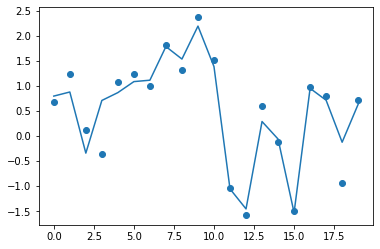

In [ ]:
plt.plot(training_z_obs)
plt.scatter(np.arange(data_size),training_data_obs)

# DELFI 1D

In [ ]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=param_inferred,
                                                 n_data=data_size, n_hiddens=[data_size*2, data_size*2],
                                                 n_mades=data_size+1, act_fun=tf.tanh, index=0)]

In [ ]:
# Set priors
lower = np.array([-10]*param_inferred)
upper = np.array([10]*param_inferred)
prior = priors.Uniform(lower, upper)

In [ ]:
param_names = []
for i in range(param_inferred):
    param_names.append(str('\theta_' + str(i)))

In [ ]:
DelfiEnsemble = delfi.Delfi(training_data_obs, prior, NDEs,
                            param_limits = [lower, upper],
                            param_names = param_names, 
                            results_dir = 'temp_marginal/')

In [ ]:
DelfiEnsemble.load_simulations(training_data, (training_z[:,:param_inferred]))

In [ ]:
DelfiEnsemble.train_ndes(batch_size=4000)

In [ ]:
def initial_parameters(theta, relative_sigma):
    """
    This is not randomise the initial position of the
    :param theta: list/array of parameter values
    :param relative_sigma: controls variance of random draws
    :return: the theta array but with random shifts
    """
    theta = np.array(theta)
    return np.random.normal(theta, np.abs(theta * relative_sigma))

def log_prior(theta, data,cov_signal_inv):
    return -0.5*np.inner(theta,np.inner(cov_signal_inv,theta))

def log_likelihood(theta, data,cov_noise_inv):
    return -0.5*np.inner(theta-data,np.inner(cov_noise_inv,theta-data))

def log_posterior_delfi(theta, data,cov_signal_inv):
    return  DelfiEnsemble.log_likelihood_stacked(theta,data=data) 

# log_prior(theta, data,cov_signal_inv) +

def log_posterior_likelihood(theta, data,cov_signal_inv,cov_noise_inv):
    return log_likelihood(theta, data,cov_noise_inv)

In [ ]:
n_dim=param_inferred 
n_burn=100
n_steps = 10000
n_walkers = 2* n_dim


sampler_delfi = mc.EnsembleSampler(n_walkers, n_dim, log_posterior_delfi,
                             args=(training_data_obs,cov_signal_inv,))


sampler_likelihood = mc.EnsembleSampler(2* data_size, data_size, log_posterior_likelihood,
                             args=(training_data_obs,cov_signal_inv,cov_noise_inv,))

In [ ]:
t = time.time()

theta_expected_mean = [0.1]*param_inferred
theta0 = np.array([list(initial_parameters(theta_expected_mean, 1)) for i in range(n_walkers)])
_ =sampler_delfi.run_mcmc(theta0, n_steps)

print(time.time() - t)

flat_samples_delfi = sampler_delfi.get_chain(discard=n_burn, flat=True)
print(flat_samples_delfi.shape)

152.98928809165955
(39600, 2)


In [ ]:
t = time.time()

theta_expected_mean = [0.1]*data_size
theta0 = np.array([list(initial_parameters(theta_expected_mean, 1)) for i in range(2*data_size)])
_ =sampler_likelihood.run_mcmc(theta0, n_steps) 

print(time.time() - t)

flat_samples_likelihood = sampler_likelihood.get_chain(discard=n_burn, flat=True)
print(flat_samples_likelihood.shape)

7.0327959060668945
(396000, 20)


Removed no burn in
Removed no burn in


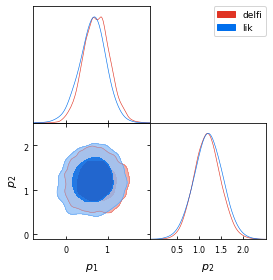

In [ ]:
names = param_names
labels =  param_names
samples = MCSamples(samples=flat_samples_delfi, label='delfi',
               settings={'smooth_scale_2D':1})
samples2 = MCSamples(samples=flat_samples_likelihood[:,:2], label='lik',
               settings={'smooth_scale_2D':1})

g = plots.get_subplot_plotter()
g.triangle_plot([samples, samples2], filled=True)